# Project 7 - Logistic Regression and SVM
Andrew Curtis and Josh Urry

## Part One: Fraud

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import statsmodels.formula.api as smf

import time
import math

In [2]:
# Import data
transactions = pd.read_csv("card_transdata.csv")
transactions.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
# See if there are missing values
transactions.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [4]:
# Number of samples
len(transactions)

1000000

In [5]:
# Charts and svm are going to take forever with this much data. Since this project is more exploratory than focused on 
# accuracy, let's take a sample of 100,000
transactions = transactions.sample(100000, random_state = 1)

### Set up data for testing

In [6]:
train, test = train_test_split(transactions, random_state = 10)

In [7]:
# Look at descriptives
train.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000
mean,26.508643,4.949160,1.829464,0.883440,0.348653,0.100333,0.65140,0.088187
std,62.054950,20.228460,2.881347,0.320897,0.476547,0.300446,0.47653,0.283568
min,0.036085,0.000319,0.011966,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.907042,0.298270,0.471658,1.000000,0.000000,0.000000,0.00000,0.000000
50%,10.011673,0.992946,0.988374,1.000000,0.000000,0.000000,1.00000,0.000000
75%,25.831763,3.340721,2.101892,1.000000,1.000000,0.000000,1.00000,0.000000
max,3986.278366,1235.861381,168.137909,1.000000,1.000000,1.000000,1.00000,1.000000


In [8]:
# Standardize the non-binary variables for the training and test data
scaler = StandardScaler()
non_binary_train = train[["distance_from_home", "distance_from_last_transaction", 
                                                          "ratio_to_median_purchase_price"]]
non_binary_test = test[["distance_from_home", "distance_from_last_transaction", 
                                                          "ratio_to_median_purchase_price"]]
standardized_train = scaler.fit_transform(non_binary_train)
standardized_test = scaler.transform(non_binary_test)

In [9]:
# Move standardized columns over
train.distance_from_home = standardized_train[: , 0]
train.distance_from_last_transaction = standardized_train[: , 1]
train.ratio_to_median_purchase_price = standardized_train[: , 2]

test.distance_from_home = standardized_test[: , 0]
test.distance_from_last_transaction = standardized_test[: , 1]
test.ratio_to_median_purchase_price = standardized_test[: , 2]

In [10]:
train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
207910,3.690104,-0.155449,-0.212792,1.0,1.0,0.0,1.0,0.0
503236,-0.372581,-0.157767,-0.540589,1.0,1.0,0.0,0.0,0.0
991602,-0.295427,-0.054307,-0.469457,1.0,1.0,1.0,0.0,0.0
544105,0.362236,-0.205595,-0.460883,1.0,0.0,0.0,1.0,0.0
207522,-0.294688,-0.210899,-0.480257,1.0,0.0,0.0,1.0,0.0


In [11]:
test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
576833,1.138509,-0.213718,0.755603,1.0,1.0,0.0,1.0,1.0
917412,2.914614,-0.165393,0.649061,1.0,0.0,0.0,1.0,1.0
530407,-0.267980,-0.234430,-0.197170,1.0,1.0,0.0,1.0,0.0
266472,-0.266283,0.195404,-0.309442,1.0,1.0,0.0,0.0,0.0
359775,-0.143668,-0.147047,-0.335936,1.0,0.0,1.0,0.0,0.0


In [12]:
X_train = train.drop("fraud", axis = 1)
y_train = train.fraud

X_test = test.drop("fraud", axis = 1)
y_test = test.fraud

In [13]:
# Look at mean absolute deviation (MAD) do see which features have the most variability
mads = X_train.mad()
mads

C:\Users\twjos\AppData\Local\Temp\ipykernel_16096\2278791294.py:2: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mads = X_train.mad()


distance_from_home                0.439227
distance_from_last_transaction    0.307816
ratio_to_median_purchase_price    0.533486
repeat_retailer                   0.205948
used_chip                         0.454188
used_pin_number                   0.180533
online_order                      0.454156
dtype: float64

In [14]:
# Now let's look at correlation matrix to see if any variables could be removed, as well as strength of relation with fraud.
corr_matrix = train.corr()
corr_matrix

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.001250,-0.003139,0.148754,-0.000355,-0.009427,0.002596,0.196096
distance_from_last_transaction,0.001250,1.000000,0.004179,0.003476,-0.001798,0.004932,-0.001638,0.112242
ratio_to_median_purchase_price,-0.003139,0.004179,1.000000,-0.004372,0.002826,-0.000642,0.001469,0.461479
repeat_retailer,0.148754,0.003476,-0.004372,1.000000,0.006446,-0.003027,0.000570,0.000282
used_chip,-0.000355,-0.001798,0.002826,0.006446,1.000000,-0.002758,-0.000379,-0.060187
used_pin_number,-0.009427,0.004932,-0.000642,-0.003027,-0.002758,1.000000,-0.009014,-0.100569
online_order,0.002596,-0.001638,0.001469,0.000570,-0.000379,-0.009014,1.000000,0.192179
fraud,0.196096,0.112242,0.461479,0.000282,-0.060187,-0.100569,0.192179,1.000000


Based on the mads and correlations, ratio to median purchase price and online order look to be some of the most predictive features since they have a relatively high mad and linear relation with fraud. It looks like repeat_retailer and used pin number may be the least predictive. However, since there aren't that many variables, let's just keep those in. It also doesn't look like we need to be too worried about multicolinearity.

<AxesSubplot: xlabel='online_order', ylabel='ratio_to_median_purchase_price'>

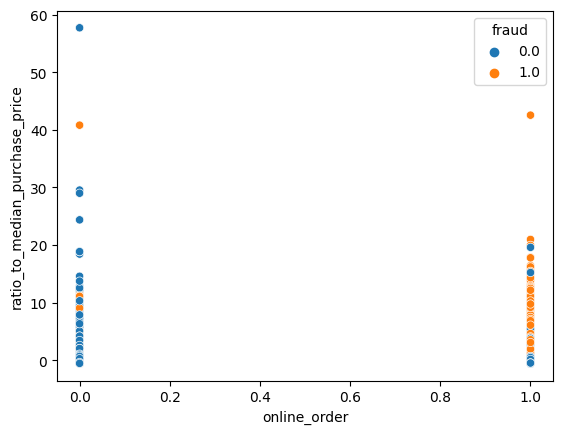

In [15]:
# Let's look at the median purchase price and online order in relation to fraud
sns.scatterplot(x = train.online_order, y = train.ratio_to_median_purchase_price, hue = transactions.fraud)
# plt.savefig("figs/orig_online_ratio.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

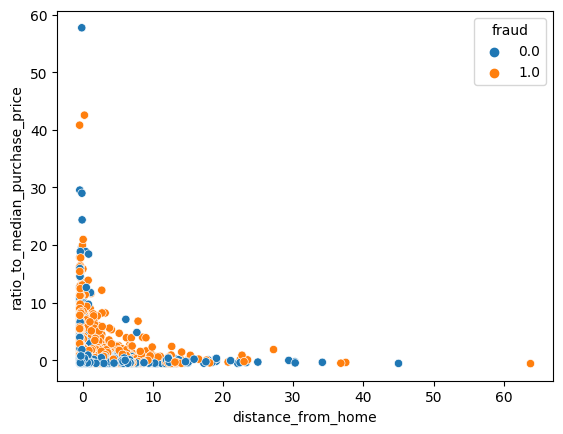

In [16]:
# Let's look at the distance from home and median purchase price in relation to fraud
sns.scatterplot(x = train.distance_from_home, y = train.ratio_to_median_purchase_price, 
                hue = train.fraud)
# plt.savefig("figs/orig_distance_ratio.png", bbox_inches = "tight")

### Logistic Regression

In [17]:
LR = LogisticRegression()

In [18]:
# Cross Validation based on F1 score
LR_train_ac = cross_val_score(LR, X_train, y_train, cv = 10, n_jobs = -1)
print(f"Mean Accuracy: {np.mean(LR_train_ac)}")
LR_train_scores = cross_val_score(LR, X_train, y_train, scoring = "f1", cv = 10, n_jobs = -1)
print(f"Mean F1: {np.mean(LR_train_scores)}")

Mean Accuracy: 0.9571866666666666
Mean F1: 0.7082053050224079


In [19]:
# Make predictions with test data
start = time.time() # keep track of elapsed time
LR.fit(X_train, y_train) # fit training data
log_preds = LR.predict(X_test) # Predict on test data
end = time.time()
# calculate scoring metrics
(p, r, f, s) = precision_recall_fscore_support(y_test, log_preds, pos_label=1, labels=[0])
print(f"precision: {p[0]}\nrecall: {r[0]}\nf1score: {f[0]}")
print(f"Elapsed time: {end - start}")

precision: 0.9621286181833638
recall: 0.993111920326416
f1score: 0.9773747841105355
Elapsed time: 0.1460247039794922


In [20]:
LR.coef_

array([[  0.96007754,   0.55275226,   2.45085059,  -0.58346009,
         -1.0351725 , -11.40935642,   6.21676669]])

<AxesSubplot: xlabel='online_order', ylabel='ratio_to_median_purchase_price'>

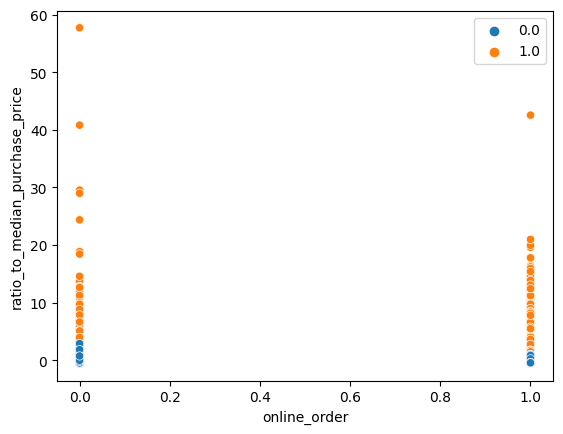

In [21]:
# Let's look at the scatters from above with the predicted values
# We'll need to fit a model to just these vairables to see the decision boundary
X_temp = X_train[["ratio_to_median_purchase_price", "online_order"]]
LR.fit(X_temp, y_train)
temp_preds = LR.predict(X_temp)
sns.scatterplot(x = X_train.online_order, y = X_train.ratio_to_median_purchase_price, hue = temp_preds)
# plt.savefig("figs/log_online_ratio.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

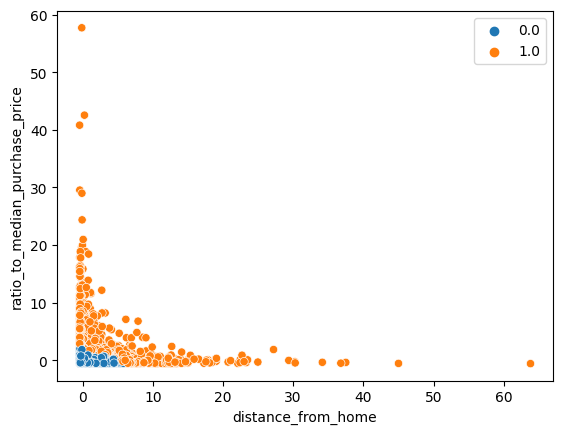

In [22]:
# Let's look at the distance from home and median purchase price in relation to fraud
X_temp = X_train[["ratio_to_median_purchase_price", "distance_from_home"]]
LR.fit(X_temp, y_train)
temp_preds = LR.predict(X_temp)
sns.scatterplot(x = X_train.distance_from_home, y = X_train.ratio_to_median_purchase_price, 
                hue = temp_preds)
# plt.savefig("figs/log_distance_ratio.png", bbox_inches = "tight")

(0.0, 10.0)

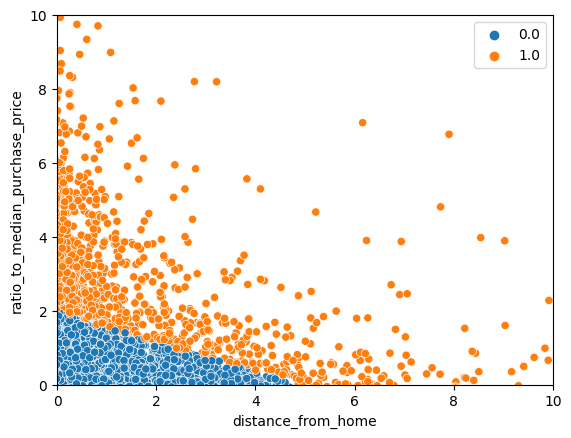

In [23]:
# Zoom in on boundary
sns.scatterplot(x = X_train.distance_from_home, y = X_train.ratio_to_median_purchase_price, 
                hue = temp_preds)
plt.xlim(0, 10)
plt.ylim(0, 10)
# plt.savefig("figs/log_distance_ratio_zoomed.png", bbox_inches = "tight")

## SVM

Poly

In [24]:
poly = svm.SVC(kernel = "poly")

In [25]:
# Cross Validation based on F1 score (lets only do 5 since svc requires more computation power)
poly_train_ac = cross_val_score(poly, X_train, y_train, n_jobs = -1)
print(f"Mean Accuracy: {np.mean(poly_train_ac)}")
poly_train_scores = cross_val_score(poly, X_train, y_train, scoring = "f1", n_jobs = -1)
print(f"Mean F1: {np.mean(poly_train_scores)}")

Mean Accuracy: 0.9915200000000001
Mean F1: 0.9504141621413147


In [26]:
# Make predictions with test data
start = time.time() # keep track of elapsed time
poly.fit(X_train, y_train) # fit training data
poly_preds = poly.predict(X_test) # Predict on test data
end = time.time()
# calculate scoring metrics
(p, r, f, s) = precision_recall_fscore_support(y_test, poly_preds, pos_label=1, labels=[0])
print(f"precision: {p[0]}\nrecall: {r[0]}\nf1score: {f[0]}")
print(f"Elapsed time: {end - start}")

precision: 0.9921977159794264
recall: 0.9986838064317992
f1score: 0.9954301956925768
Elapsed time: 31.30182909965515


In [27]:
#To save some time, let's cut down the training data to view the decision boundary
train_small = train.sample(5000, random_state = 1)

<AxesSubplot: xlabel='online_order', ylabel='ratio_to_median_purchase_price'>

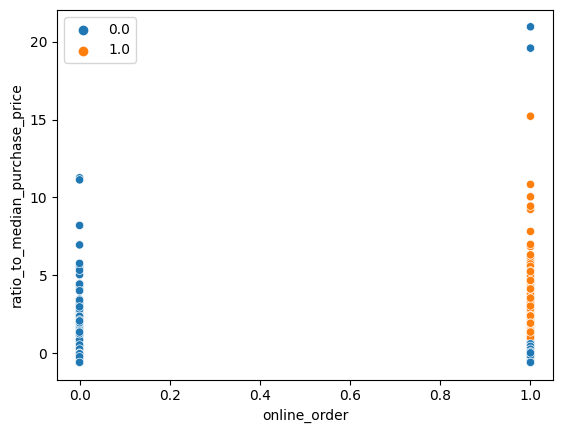

In [28]:
# Let's look at the scatters from above with the predicted values
# We'll need to fit a model to just these vairables to see the decision boundary
X_temp = train_small[["ratio_to_median_purchase_price", "online_order"]]
poly.fit(X_temp, train_small.fraud)
temp_preds = poly.predict(X_temp)
sns.scatterplot(x = X_temp.online_order, y = X_temp.ratio_to_median_purchase_price, hue = temp_preds)
# plt.savefig("figs/poly_online_ratio.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

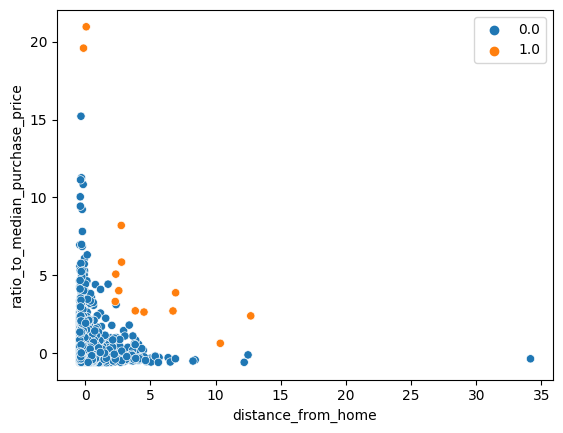

In [29]:
# Let's look at the distance from home and median purchase price in relation to fraud
poly = svm.SVC(kernel = "poly")
X_temp = train_small[["ratio_to_median_purchase_price", "distance_from_home"]]
poly.fit(X_temp, train_small.fraud)
temp_preds = poly.predict(X_temp)
sns.scatterplot(x = X_temp.distance_from_home, y = X_temp.ratio_to_median_purchase_price, 
                hue = temp_preds)
# plt.savefig("figs/poly_distance_ratio.png", bbox_inches = "tight")

rbf

In [30]:
rbf = svm.SVC(kernel = "rbf")

In [31]:
# Cross Validation based on F1 score (lets only do 5 since svc requires more computation power)
rbf_train_ac = cross_val_score(rbf, X_train, y_train, n_jobs = -1)
print(f"Mean Accuracy: {np.mean(rbf_train_ac)}")
rbf_train_scores = cross_val_score(rbf, X_train, y_train, scoring = "f1", n_jobs = -1)
print(f"Mean F1: {np.mean(rbf_train_scores)}")

Mean Accuracy: 0.9952266666666667
Mean F1: 0.972522953089428


In [32]:
# Make predictions with test data
start = time.time() # keep track of elapsed time
rbf.fit(X_train, y_train) # fit training data
rbf_preds = rbf.predict(X_test) # Predict on test data
end = time.time()
# calculate scoring metrics
(p, r, f, s) = precision_recall_fscore_support(y_test, rbf_preds, pos_label=1, labels=[0])
print(f"precision: {p[0]}\nrecall: {r[0]}\nf1score: {f[0]}")
print(f"Elapsed time: {end - start}")

precision: 0.9961511546536039
recall: 0.9992541569780196
f1score: 0.9977002431171561
Elapsed time: 18.843281269073486


<AxesSubplot: xlabel='online_order', ylabel='ratio_to_median_purchase_price'>

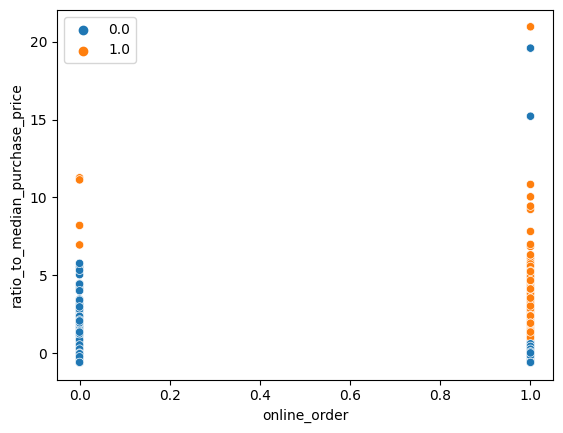

In [33]:
# Let's look at the scatters from above with the predicted values
# We'll need to fit a model to just these vairables to see the decision boundary
rbf = svm.SVC(kernel = "rbf")
X_temp = train_small[["ratio_to_median_purchase_price", "online_order"]]
rbf.fit(X_temp, train_small.fraud)
temp_preds = rbf.predict(X_temp)
sns.scatterplot(x = X_temp.online_order, y = X_temp.ratio_to_median_purchase_price, hue = temp_preds)
# plt.savefig("figs/rbf_online_ratio.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

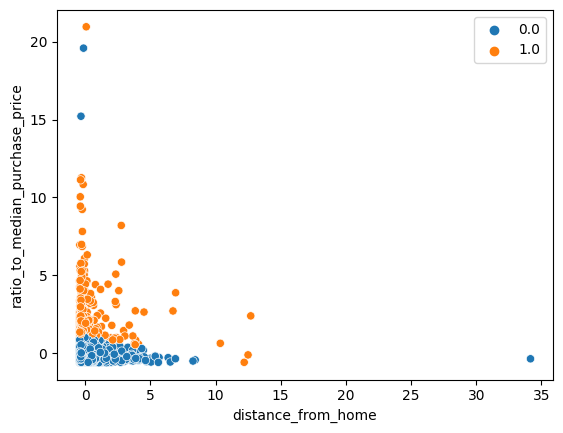

In [34]:
# Let's look at the distance from home and median purchase price in relation to fraud
rbf = svm.SVC(kernel = "rbf")
X_temp = train_small[["ratio_to_median_purchase_price", "distance_from_home"]]
rbf.fit(X_temp, train_small.fraud)
temp_preds = rbf.predict(X_temp)
sns.scatterplot(x = X_temp.distance_from_home, y = X_temp.ratio_to_median_purchase_price, 
                hue = temp_preds)
# plt.savefig("figs/rbf_distance_ratio.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

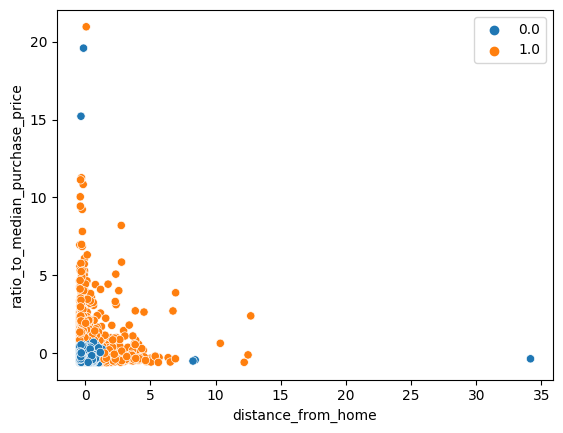

In [35]:
# Change class weight to favor fraud
rbf = svm.SVC(kernel = "rbf", class_weight={0:1, 1:5})
X_temp = train_small[["ratio_to_median_purchase_price", "distance_from_home"]]
rbf.fit(X_temp, train_small.fraud)
temp_preds = rbf.predict(X_temp)
sns.scatterplot(x = X_temp.distance_from_home, y = X_temp.ratio_to_median_purchase_price, 
                hue = temp_preds)
# plt.savefig("figs/rbf_distance_ratio_weightedFraud.png", bbox_inches = "tight")

<AxesSubplot: xlabel='distance_from_home', ylabel='ratio_to_median_purchase_price'>

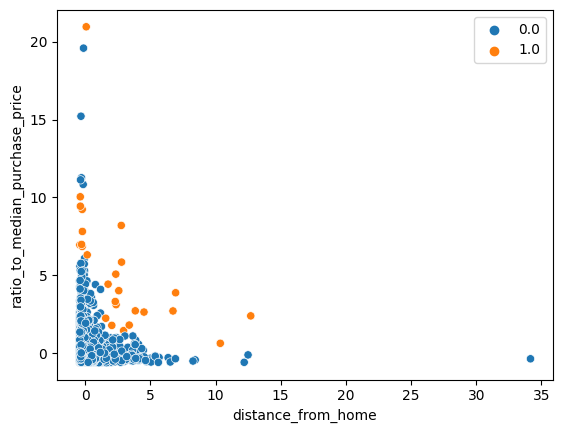

In [36]:
# Change class weight to favor non fraud
rbf = svm.SVC(kernel = "rbf", class_weight={0:5, 1:1})
X_temp = train_small[["ratio_to_median_purchase_price", "distance_from_home"]]
rbf.fit(X_temp, train_small.fraud)
temp_preds = rbf.predict(X_temp)
sns.scatterplot(x = X_temp.distance_from_home, y = X_temp.ratio_to_median_purchase_price, 
                hue = temp_preds)
# plt.savefig("figs/rbf_distance_ratio_weightedNot.png", bbox_inches = "tight")

## Part 2: Census

In [37]:
sdf = pd.read_csv("salary.csv")
sdf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [38]:
sdf.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [39]:
sdf['workclass'].isnull().sum()

0

In [40]:
sdf['native-country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

## encoding categorical variables

In [41]:
#Salary: <=50K is 0, >50K is 1
sdf['salary'] = sdf['salary'].replace([' <=50K', ' >50K'],[0,1])

#Workclass: state-gov = 0, self emp not inc = 1, private = 2, federal gov = 3, local gov = 4, ? = 5, self emp inc = 6, without pay = 7, never worked = 8
sdf['workclass'] = sdf['workclass'].replace([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'],[0,1,2,3,4,5,6,7,8])

# Education: ' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',' Some-college', ' Assoc-acdm', 
#  ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
#        ' Preschool', ' 12th'

sdf['education'] = sdf['education'].replace([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'],[1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0])

# sdf['education'] = sdf['education'].replace([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
#        ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
#        ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
#        ' Preschool', ' 12th'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])


# Marital status: [' Never-married', ' Married-civ-spouse', ' Divorced',
       # ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       # ' Widowed']
sdf['marital-status'] = sdf['marital-status'].replace([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'],[0,1,2,3,4,5,6])
# occupation: ' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       # ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       # ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       # ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       # ' Priv-house-serv'
sdf['occupation'] = sdf['occupation'].replace([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# relationship: ' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried', ' Other-relative'
sdf['relationship'] = sdf['relationship'].replace([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'],[0,1,2,3,4,5])

#race: ' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',' Other'
sdf['race'] = sdf['race'].replace([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'],[0,1,2,3,4])

sdf['sex'] = sdf['sex'].replace([' Male', ' Female'],[0,1])

# native country: ' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
#        ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
#        ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
#        ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
#        ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
#        ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
#        ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
#        ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
#        ' Ireland', ' Hungary', ' Holand-Netherlands'

sdf['native-country'] = sdf['native-country'].replace([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
        20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41])
                                                      
sdf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,0,77516,1,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,1,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,0,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,0,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,1,13,1,3,2,1,1,0,0,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,2,257302,0,12,1,10,2,0,1,0,0,38,0,0
32557,40,2,154374,0,9,1,9,1,0,0,0,0,40,0,1
32558,58,2,151910,0,9,6,0,4,0,1,0,0,40,0,0
32559,22,2,201490,0,9,0,0,3,0,0,0,0,20,0,0


In [42]:
# sdf = sdf.loc[sdf["hours-per-week"] == 40]
# sdf

In [43]:
# sdf['education'] = sdf['education'].replace([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
#        ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
#        ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
#        ' Preschool', ' 12th'],[1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0])

<AxesSubplot: xlabel='salary', ylabel='Count'>

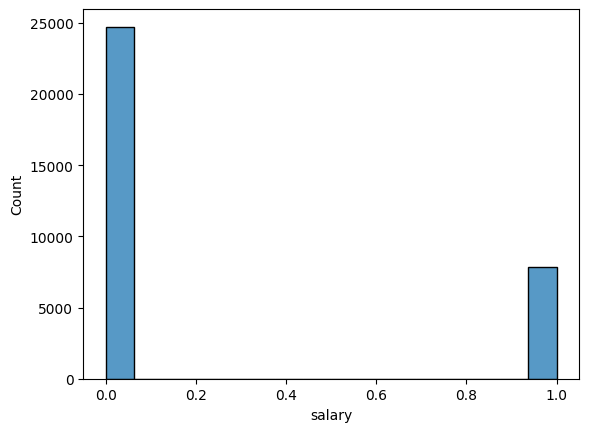

In [44]:
sns.histplot(sdf.salary)
# plt.savefig("salary_before")

## Balance Salary Class

In [45]:
df_for_training_grouped = sdf.groupby("salary")
df_for_training_grouped.groups.values()
frames_of_groups = [x.sample(df_for_training_grouped.size().min()) for y, x in df_for_training_grouped]
new_sdf = pd.concat(frames_of_groups)

<AxesSubplot: xlabel='salary', ylabel='Count'>

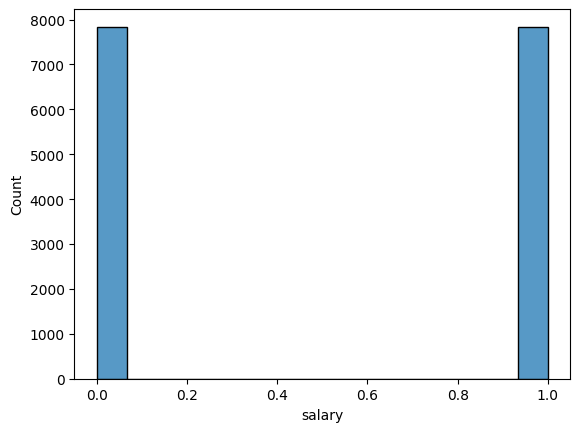

In [46]:
sns.histplot(new_sdf.salary)
# plt.savefig("salary_aftersampling")

Text(0.5, 1.0, 'Distribution of samples with or without 4-year degrees')

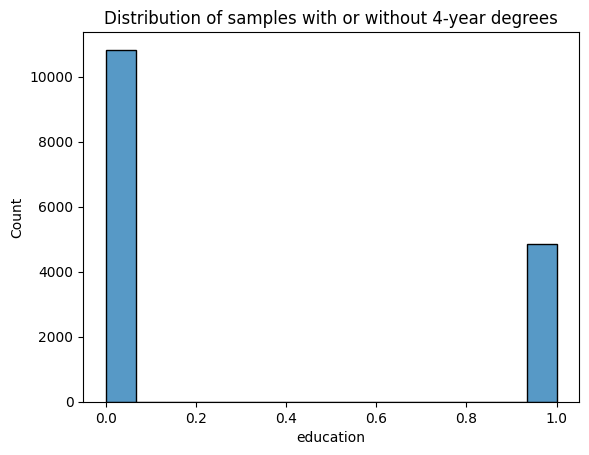

In [47]:
sns.histplot(new_sdf.education)
plt.title("Distribution of samples with or without 4-year degrees")
# plt.savefig("education_distribution")

<AxesSubplot: xlabel='age', ylabel='salary'>

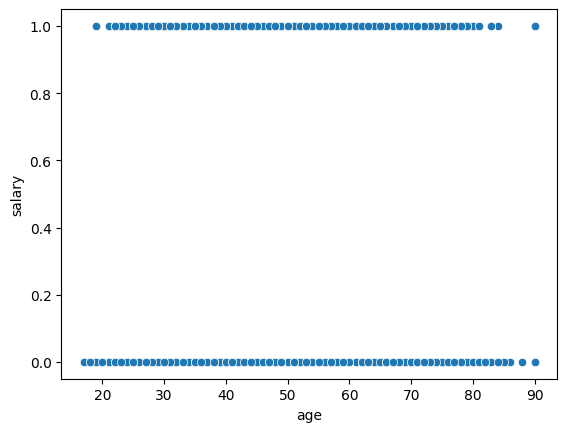

In [48]:
sns.scatterplot(x=new_sdf.age, y=new_sdf.salary)

<AxesSubplot: xlabel='education', ylabel='age'>

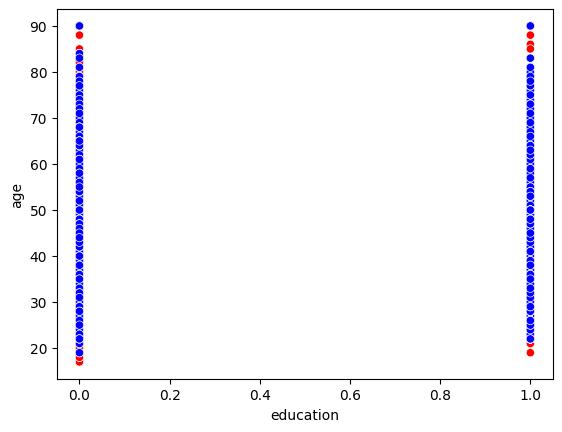

In [49]:
color = ['r' if  salary == 0 else 'b' for salary in new_sdf.salary]
# plt.scatter(df.x1, df.x2, c=color, s=10)
sns.scatterplot(data=sdf, x=new_sdf.education, y=new_sdf.age, c= color)

Text(0.5, 1.0, 'Red=<50K, Blue=>50K Income')

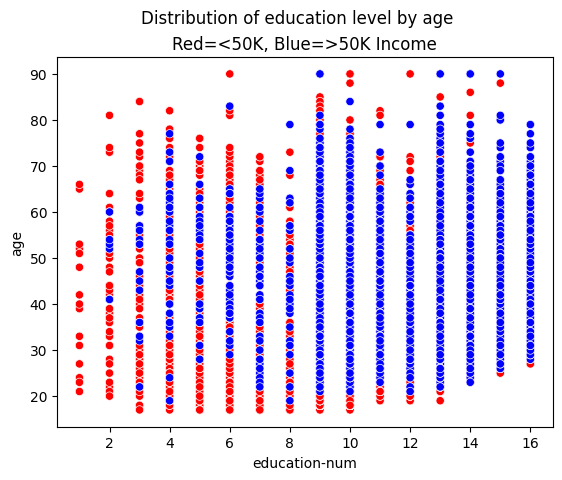

In [50]:
color = ['r' if  salary == 0 else 'b' for salary in new_sdf.salary]
# plt.scatter(df.x1, df.x2, c=color, s=10)
sns.scatterplot(data=sdf, x=new_sdf['education-num'], y=new_sdf.age, c= color)
plt.suptitle("Distribution of education level by age")
plt.title("Red=<50K, Blue=>50K Income")
# plt.savefig('ed_lvl_age')

<AxesSubplot: xlabel='education', ylabel='hours-per-week'>

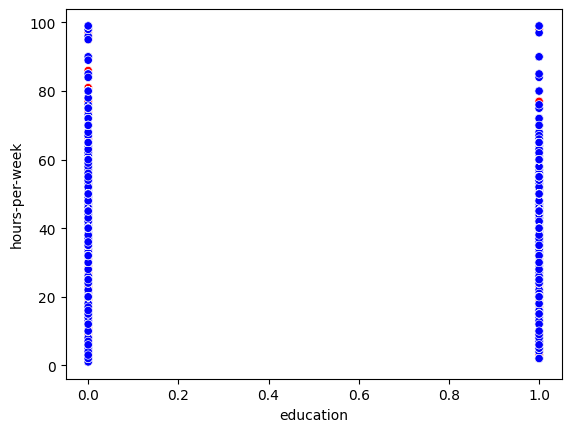

In [51]:
color = ['r' if  salary == 0 else 'b' for salary in new_sdf.salary]
# plt.scatter(df.x1, df.x2, c=color, s=10)
sns.scatterplot(data=sdf, x=new_sdf.education, y=new_sdf['hours-per-week'], c= color)

Text(0.5, 0.98, 'Distribution of education level by hours per week worked')

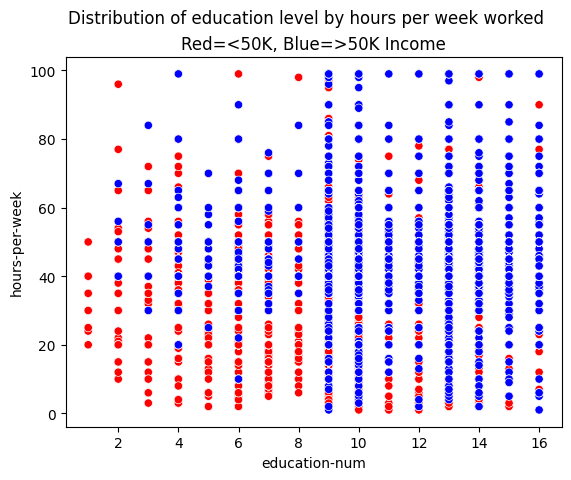

In [52]:
color = ['r' if  salary == 0 else 'b' for salary in new_sdf.salary]
# plt.scatter(df.x1, df.x2, c=color, s=10)
sns.scatterplot(data=sdf, x=new_sdf['education-num'], y=new_sdf['hours-per-week'], c= color)

plt.title("Red=<50K, Blue=>50K Income")
plt.suptitle("Distribution of education level by hours per week worked")
# plt.savefig('ed_lvl_hoursper')

Text(0.5, 0.98, 'Distribution of age and hours per week worked')

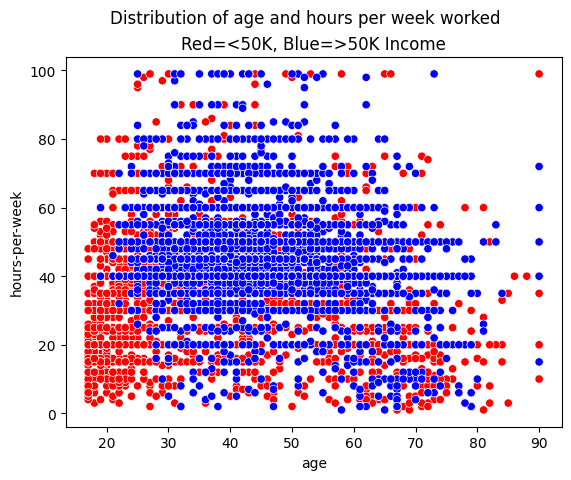

In [53]:
color = ['r' if  salary == 0 else 'b' for salary in new_sdf.salary]
# plt.scatter(df.x1, df.x2, c=color, s=10)
sns.scatterplot(data=sdf, x=new_sdf['age'], y=new_sdf['hours-per-week'], c= color)

plt.title("Red=<50K, Blue=>50K Income")
plt.suptitle("Distribution of age and hours per week worked")
# plt.savefig('age_hoursper')

In [54]:
# X = sdf[['age', 'workclass', 'fnlwgt', 'education', 'education-num',
#        'marital-status', 'occupation', 'relationship', 'race', 'sex',
#        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
# y = sdf.salary

# clf = svm.SVC(kernel='linear')
# clf.fit(X, y)

# y_pred = clf.predict(X)
# p,r,f,s = precision_recall_fscore_support(y, y_pred)
# display('precision = {}'.format(p))
# display('recall = {}'.format(r))
# display('f-score = {}'.format(f))


In [55]:
print(len(new_sdf))

15682


## Model Testing

In [56]:
X = new_sdf[['education-num', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='linear', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7221203666799522
CV average score: 0.72
[[1104  492]
 [ 386 1155]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      1596
           1       0.70      0.75      0.72      1541

    accuracy                           0.72      3137
   macro avg       0.72      0.72      0.72      3137
weighted avg       0.72      0.72      0.72      3137



In [57]:
X = new_sdf[['age']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='linear', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.6493423674770825
CV average score: 0.65
[[ 929  643]
 [ 456 1109]]
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      1572
           1       0.63      0.71      0.67      1565

    accuracy                           0.65      3137
   macro avg       0.65      0.65      0.65      3137
weighted avg       0.65      0.65      0.65      3137



In [58]:
X = new_sdf[['hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='linear', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.6316460741331208
CV average score: 0.63
[[1206  372]
 [ 829  730]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.67      1578
           1       0.66      0.47      0.55      1559

    accuracy                           0.62      3137
   macro avg       0.63      0.62      0.61      3137
weighted avg       0.63      0.62      0.61      3137



In [59]:
X = new_sdf[['education']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='linear', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.6539657233957752
CV average score: 0.65
[[1304  239]
 [ 905  689]]
              precision    recall  f1-score   support

           0       0.59      0.85      0.70      1543
           1       0.74      0.43      0.55      1594

    accuracy                           0.64      3137
   macro avg       0.67      0.64      0.62      3137
weighted avg       0.67      0.64      0.62      3137



In [60]:
X = new_sdf[['education-num']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='linear', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.6658429653248306
CV average score: 0.67
[[1256  302]
 [ 724  855]]
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      1558
           1       0.74      0.54      0.62      1579

    accuracy                           0.67      3137
   macro avg       0.69      0.67      0.67      3137
weighted avg       0.69      0.67      0.67      3137



In [61]:
X = new_sdf[['education-num', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='poly', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7325627740135512
CV average score: 0.73
[[1155  398]
 [ 462 1122]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1553
           1       0.74      0.71      0.72      1584

    accuracy                           0.73      3137
   macro avg       0.73      0.73      0.73      3137
weighted avg       0.73      0.73      0.73      3137



In [62]:
X = new_sdf[['education-num', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='poly', C=1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.729214826624153
CV average score: 0.73
[[1222  353]
 [ 507 1055]]
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      1575
           1       0.75      0.68      0.71      1562

    accuracy                           0.73      3137
   macro avg       0.73      0.73      0.73      3137
weighted avg       0.73      0.73      0.73      3137



In [63]:
X = new_sdf[['education-num', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='rbf', C=0.1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7338381825428457
CV average score: 0.73
[[1002  535]
 [ 318 1282]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1537
           1       0.71      0.80      0.75      1600

    accuracy                           0.73      3137
   macro avg       0.73      0.73      0.73      3137
weighted avg       0.73      0.73      0.73      3137



In [64]:
X = new_sdf[['education', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='rbf', C=1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7081705858907932
CV average score: 0.71
[[ 879  662]
 [ 274 1322]]
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1541
           1       0.67      0.83      0.74      1596

    accuracy                           0.70      3137
   macro avg       0.71      0.70      0.70      3137
weighted avg       0.71      0.70      0.70      3137



In [65]:
X = new_sdf[['education-num', 'age', 'hours-per-week']]
y = new_sdf.salary

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)
clf = svm.SVC(kernel='rbf', C=1)

clf.fit(xtrain, ytrain)
score = clf.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7380629732961339
CV average score: 0.74
[[1016  556]
 [ 270 1295]]
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1572
           1       0.70      0.83      0.76      1565

    accuracy                           0.74      3137
   macro avg       0.74      0.74      0.73      3137
weighted avg       0.74      0.74      0.73      3137



## Logistic Model

In [66]:
X = new_sdf[['workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'native-country']]
y = new_sdf.salary



# print(lm.intercept_)
# print(lm.coef_)

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)

lm = LogisticRegression()
lm.fit(X, y)

lm.fit(xtrain, ytrain)
score = lm.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(lm, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = lm.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.7044240733359904
CV average score: 0.71
[[1132  451]
 [ 477 1077]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1583
           1       0.70      0.69      0.70      1554

    accuracy                           0.70      3137
   macro avg       0.70      0.70      0.70      3137
weighted avg       0.70      0.70      0.70      3137



In [67]:
X = new_sdf[['education', 'age', 'hours-per-week']]
y = new_sdf.salary



# print(lm.intercept_)
# print(lm.coef_)

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2)

lm = LogisticRegression()
lm.fit(X, y)

lm.fit(xtrain, ytrain)
score = lm.score(xtrain, ytrain)
print("Score: ", score)

cv_scores = cross_val_score(lm, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = lm.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

cr = classification_report(ytest, ypred)
print(cr) 

Score:  0.6892785970506178
CV average score: 0.69
[[1056  454]
 [ 528 1099]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1510
           1       0.71      0.68      0.69      1627

    accuracy                           0.69      3137
   macro avg       0.69      0.69      0.69      3137
weighted avg       0.69      0.69      0.69      3137

